### This is a computational acoustic tutorial based on Finite Element Method (FEM) by using in-house developed Python code


Let consider an acoustic wave propagation problem in two-media domain. 

The first medium is a fluid (air) and the second one is a porous material which is able to absorb the sound wave. The left side is subjected to a unit velocity excitation and a rigid wall is bounded the right side of the domain. 

This test case is a very typical kundlt tube measurement set-up. The schematic of the problem is shown in the following figure:

![problem setup](figs/prob_1d_1.png)

Let import the required libraries and FEM modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/shaoqi/Devlop/PyXfem/PyAcoustiX/')  # add the path of PyAcoustiX


Set the problem parameters and material properties

In [2]:
from SAcouS.acxfem.materials import Air, EquivalentFluid

air = Air('classical air')  # create an air object with name
# cporous material properties
phi          = 0.98  # porosity
sigma        = 3.75e3 # resistivity
alpha        = 1.17  # Tortuosity
Lambda_prime = 742e-6  # Viscous characteristic length
Lambda       = 110e-6  #  thermal characteristic length
foam = EquivalentFluid('foam', phi, sigma, alpha, Lambda_prime, Lambda)  # create a porous material object with name

Excitation frequency

In [3]:
frequency = 1000  # Hz
omega = 2 * np.pi * frequency  # angular frequency

Mesh and two-media domain definition

In [4]:
from SAcouS.acxfem.mesh import Mesh1D  # import 1D mesh class

num_elem = 200  # number of elements
num_nodes = num_elem + 1  # number of nodes
nodes = np.linspace(-1, 1, num_nodes)

elem_connec1 = np.arange(0, num_elem)
elem_connec2 = np.arange(1, num_nodes)
connectivity = np.vstack((elem_connec1, elem_connec2)).T
# crate 1D mesh with nodes coordinates and connectivity
mesh = Mesh1D(nodes, connectivity)
mesh.get_mesh_coordinates()  # get mesh information: element number: coordinates
# mesh.get_nodes_from_elem()[1]

{0: array([-1.  , -0.99]),
 1: array([-0.99, -0.98]),
 2: array([-0.98, -0.97]),
 3: array([-0.97, -0.96]),
 4: array([-0.96, -0.95]),
 5: array([-0.95, -0.94]),
 6: array([-0.94, -0.93]),
 7: array([-0.93, -0.92]),
 8: array([-0.92, -0.91]),
 9: array([-0.91, -0.9 ]),
 10: array([-0.9 , -0.89]),
 11: array([-0.89, -0.88]),
 12: array([-0.88, -0.87]),
 13: array([-0.87, -0.86]),
 14: array([-0.86, -0.85]),
 15: array([-0.85, -0.84]),
 16: array([-0.84, -0.83]),
 17: array([-0.83, -0.82]),
 18: array([-0.82, -0.81]),
 19: array([-0.81, -0.8 ]),
 20: array([-0.8 , -0.79]),
 21: array([-0.79, -0.78]),
 22: array([-0.78, -0.77]),
 23: array([-0.77, -0.76]),
 24: array([-0.76, -0.75]),
 25: array([-0.75, -0.74]),
 26: array([-0.74, -0.73]),
 27: array([-0.73, -0.72]),
 28: array([-0.72, -0.71]),
 29: array([-0.71, -0.7 ]),
 30: array([-0.7 , -0.69]),
 31: array([-0.69, -0.68]),
 32: array([-0.68, -0.67]),
 33: array([-0.67, -0.66]),
 34: array([-0.66, -0.65]),
 35: array([-0.65, -0.64]),
 3

In [5]:
# define subdomains: domain physic (material) and the elements in the domain
air_elements  = np.arange(0, int(num_elem/2))  # half of the elements are air
foam_elements = np.arange(int(num_elem/2), num_elem)  # half of the elements are foam
mesh.set_subdomains({air: air_elements, foam: foam_elements})  # define subdomains
# we then need to check if these two materials (physic) are compatible in the domain
from SAcouS.acxfem.utilities import check_material_compability
check_material_compability(mesh.subdomains)

Material models classical air are compatible, computation continues ...
Material models foam are compatible, computation continues ...


Great ! materials are compatible with each other and the subdoamin is well defined.

Let's construct the our FEM bases on the mesh (domain)

In [6]:
# firt import the basis (element) class
from SAcouS.acxfem.basis import Lobbato1DElement
print(mesh.get_nodes_from_elem(0))  # get the nodes coordinates of the first element
elements2node = mesh.get_mesh_coordinates()  #  get mesh information to be used to construct the bases
# In the AcoustiX, the basis can be constructed element-wise
order = 2  # order of the shape functions (globally): make sure we have sufficient dofs per wave length
Pf_bases = []
for mat, elems in mesh.subdomains.items():
    if mat.TYPE == 'Fluid':
        Pf_bases += [Lobbato1DElement('Pf', order, mesh.get_nodes_from_elem(elem)) for elem in elems]  # arguments: name, order, nodes coordinates

[-1.   -0.99]


In [7]:
# the bases , mesh and subdomains are used to construct the finite element space
from SAcouS.acxfem.dofhandler import FESpace

Helmholtz_space = FESpace(mesh, Pf_bases)  # args: bases name, bases
print(f"The number of global dofs is {Helmholtz_space.get_nb_dofs()}.")

The number of global dofs is 401.


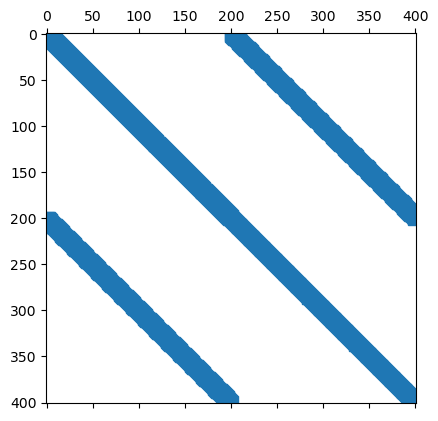

In [8]:
# assemle the global matrix, here we are treating the Helmholtz equation, 
# a wrapped Helmholtz assembler in AcoustiX can be directly used
from SAcouS.acxfem.physic_assembler import HelmholtzAssembler
# args: dof_handler, subdomains, dtype (type of left hand matrix and right hand vector)
Helmholtz_assember = HelmholtzAssembler(Helmholtz_space, mesh.subdomains, dtype=np.complex128)  # complex matrix and solution
Helmholtz_assember.assembly_global_matrix(Pf_bases, 'Pf', omega)  # assemble the global matrix with excited frequency
left_hand_matrix = Helmholtz_assember.get_global_matrix()  # get the global matrix
# the global left hand side matrix is construct, let us visualize it's sparse pattern with an AcoustiX utility
from SAcouS.acxfem.utilities import plot_matrix_partten
plot_matrix_partten(left_hand_matrix)  # display the matrix sparse partten

In [9]:
# it's time to construct the right hand side vector (boundary conditions)

from SAcouS.acxfem.BCs_impose import ApplyBoundaryConditions
# define our right hand side vector
right_hand_vec = np.zeros(Helmholtz_assember.nb_global_dofs, dtype=np.complex128)
# as velocity is excited, which a kind of Neumann (natural) boundary condition
nature_bcs = {'type': 'fluid_velocity', 'value': 1, 'position': -1}
BCs_applier = ApplyBoundaryConditions(mesh, Helmholtz_space, left_hand_matrix, right_hand_vec, omega)
BCs_applier.apply_nature_bc(nature_bcs, var='Pf')
print(f"{nature_bcs['type']} boundary condition is applied at x={nature_bcs['position']}.")

velocity boundary condition is applied at x=-1.


In [10]:
# the last step is to solve the linear system
from SAcouS.acxfem.solver import LinearSolver
linear_solver = LinearSolver(fe_space=Helmholtz_space)
linear_solver.solve(left_hand_matrix, right_hand_vec)
sol = linear_solver.u

solving time:  0.00048542022705078125


In [11]:
# to verify the our FEM solution, a reference solution is needed. 
# Here we use the analytical solution which has been implemented in AcoustiX
from analytical.fluid_sol import DoubleleLayerKundltTube
# by giving length of layer 1/2, media of layer 1/2, frequency and boundary conditions, the analytical solution can be constructed
kundlt_tube = DoubleleLayerKundltTube(1,1, air, foam, omega, nature_bcs)
ana_sol = kundlt_tube.sol_on_mesh(mesh, sol_type='pressure')  # we are interested in the pressure solution

array([ 5.82075910e+02+1.06016297e+02j,  5.72278677e+02+2.84449286e+01j,
        5.43216783e+02-5.00839831e+01j,  4.95868541e+02-1.26926914e+02j,
        4.31827838e+02-1.99497094e+02j,  3.53250482e+02-2.65351589e+02j,
        2.62781628e+02-3.22273532e+02j,  1.63466735e+02-3.68346757e+02j,
        5.86490495e+01-4.02020297e+02j, -4.81429436e+01-4.22160597e+02j,
       -1.53314297e+02-4.28089672e+02j, -2.53324620e+02-4.19607932e+02j,
       -3.44807256e+02-3.97000898e+02j, -4.24682620e+02-3.61029592e+02j,
       -4.90261860e+02-3.12904920e+02j, -5.39337377e+02-2.54246905e+02j,
       -5.70257139e+02-1.87030157e+02j, -5.81980291e+02-1.13517399e+02j,
       -5.74112196e+02-3.61832956e+01j, -5.46917718e+02+4.23688487e+01j,
       -5.01312308e+02+1.19494727e+02j, -4.38831182e+02+1.92598045e+02j,
       -3.61577649e+02+2.59217921e+02j, -2.72152300e+02+3.17111724e+02j,
       -1.73565467e+02+3.64330570e+02j, -6.91358866e+01+3.99284929e+02j,
        3.76210206e+01+4.20798129e+02j,  1.43111488

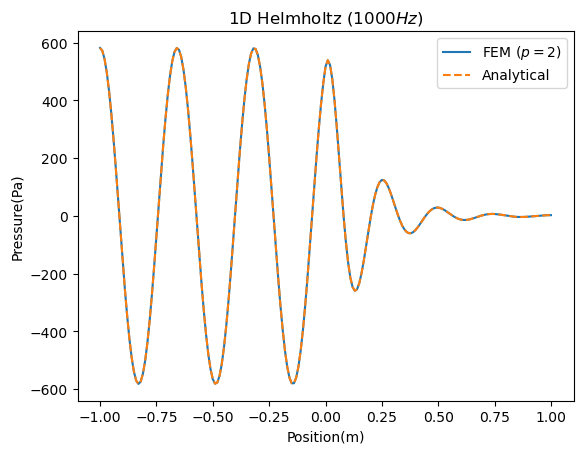

In [12]:
# Now we can compare the FEM solution with the analytical solution by plotting them
from SAcouS.acxfem.postprocess import PostProcessField

# create a postprocess object
post_processer = PostProcessField(mesh.nodes, rf'1D Helmholtz ({frequency}$Hz$)')
post_processer.plot_sol((np.real(sol), f'FEM ($p={order}$)', 'solid'), (np.real(ana_sol), 'Analytical', 'dashed'))
plt.show()

Voilà, here is our solution and the whole tutorial is done. You can play with the demo code by changing the problem, numerical parameters and see how the solution is changed, for instance:
- Change the properties of the porous material
- Change the excitation frequency
- Change the mesh size (number of elements)
- Change the polynomial order of the FEM bases
- Use different velocity to excite the domain
There are more advanced features that can be applied on this problem, for instance:
- optimize the sparsity pattern by using a method in our fem solver module
- use variable order of the FEM bases on each element
- compute the relative error of the solutions